<a href="https://colab.research.google.com/github/AbubakarMA/Abu/blob/main/Agricultural_Crop_Yield_Analysis_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Generate synthetic agricultural dataset
def generate_agricultural_data(n_samples=1000):
    """Generate synthetic crop yield data based on various agricultural factors"""

    data = {
        'temperature_avg': np.random.normal(25, 5, n_samples),  # Average temperature (°C)
        'rainfall_mm': np.random.exponential(50, n_samples),    # Rainfall (mm)
        'soil_ph': np.random.normal(6.5, 0.8, n_samples),      # Soil pH
        'nitrogen_ppm': np.random.normal(200, 50, n_samples),   # Nitrogen content (ppm)
        'phosphorus_ppm': np.random.normal(40, 15, n_samples),  # Phosphorus content (ppm)
        'potassium_ppm': np.random.normal(150, 30, n_samples),  # Potassium content (ppm)
        'organic_matter_pct': np.random.normal(3.5, 1, n_samples), # Organic matter (%)
        'irrigation_frequency': np.random.randint(1, 8, n_samples), # Irrigation per week
        'fertilizer_kg_ha': np.random.normal(150, 40, n_samples),   # Fertilizer application (kg/ha)
        'crop_type': np.random.choice(['Maize', 'Rice', 'Wheat', 'Sorghum'], n_samples),
        'season': np.random.choice(['Dry', 'Wet'], n_samples)
    }

    df = pd.DataFrame(data)
    # Create realistic yield based on factors (tons/hectare)
    base_yield = 3.5
    temp_effect = np.where(df['temperature_avg'].between(20, 30),
                         (df['temperature_avg'] - 15) * 0.1,
                         -abs(df['temperature_avg'] - 25) * 0.05)

    rainfall_effect = np.where(df['rainfall_mm'] < 100,
                             df['rainfall_mm'] * 0.01,
                             1 - (df['rainfall_mm'] - 100) * 0.002)

    ph_effect = np.where(df['soil_ph'].between(6, 7.5),
                       (df['soil_ph'] - 5.5) * 0.3,
                       -abs(df['soil_ph'] - 6.75) * 0.2)

    nutrient_effect = (df['nitrogen_ppm'] * 0.002 +
                     df['phosphorus_ppm'] * 0.01 +
                     df['potassium_ppm'] * 0.003) / 100

    organic_effect = df['organic_matter_pct'] * 0.2
    irrigation_effect = np.minimum(df['irrigation_frequency'] * 0.1, 0.5)
    fertilizer_effect = df['fertilizer_kg_ha'] * 0.003
    crop_multipliers = {'Maize': 1.2, 'Rice': 1.0, 'Wheat': 0.9, 'Sorghum': 0.8}
    crop_effect = df['crop_type'].map(crop_multipliers)

    # Season effect
    season_effect = np.where(df['season'] == 'Wet', 0.3, -0.2)

    # Calculate yield with some random noise
    df['yield_tons_ha'] = (base_yield + temp_effect + rainfall_effect + ph_effect +
                         nutrient_effect + organic_effect + irrigation_effect +
                         fertilizer_effect + season_effect) * crop_effect + np.random.normal(0, 0.3, n_samples)

    # Ensure positive yields
    df['yield_tons_ha'] = np.maximum(df['yield_tons_ha'], 0.5)

    return df

In [ ]:
df = generate_agricultural_data(1000)

In [ ]:
print("Agricultural Crop Yield Dataset")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

Agricultural Crop Yield Dataset
Dataset shape: (1000, 12)

First few rows:
   temperature_avg  rainfall_mm   soil_ph  nitrogen_ppm  phosphorus_ppm  \
0        24.326704     8.266365  6.732894    303.300796       50.582375   
1        20.540172   110.037810  7.129283    118.133546       47.742473   
2        25.898703    42.369940  6.598495    168.444591       27.407492   
3        30.272766    15.147675  6.486410    167.840410       51.582386   
4        28.627534   114.492738  6.105456    277.001258        3.009655   

   potassium_ppm  organic_matter_pct  irrigation_frequency  fertilizer_kg_ha  \
0     153.665624            4.763745                     2        150.569503   
1     199.343127            4.494330                     1        144.459824   
2     206.060997            3.022847                     7        135.286711   
3      85.084213            2.711324                     5        169.550067   
4     164.983993            3.891537                     4        132.3098

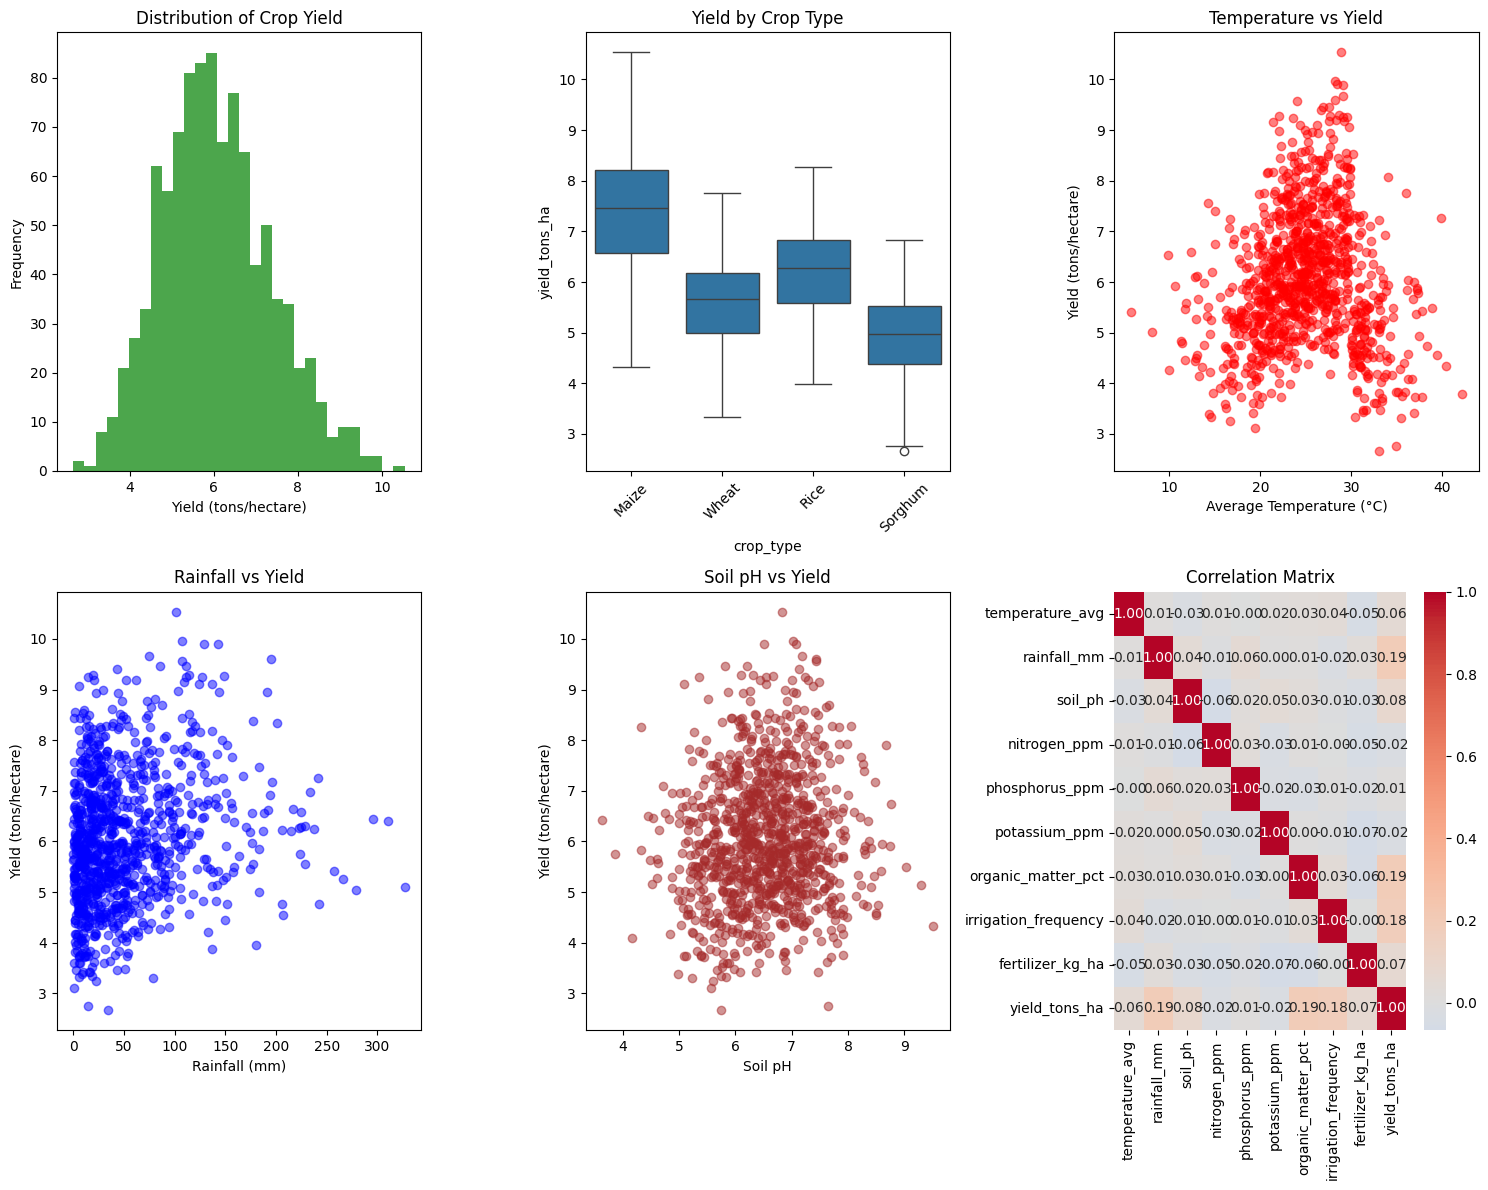

In [ ]:
plt.figure(figsize=(15, 12))

# 1. Distribution of yield
plt.subplot(2, 3, 1)
plt.hist(df['yield_tons_ha'], bins=30, alpha=0.7, color='green')
plt.title('Distribution of Crop Yield')
plt.xlabel('Yield (tons/hectare)')
plt.ylabel('Frequency')

# 2. Yield by crop type
plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='crop_type', y='yield_tons_ha')
plt.title('Yield by Crop Type')
plt.xticks(rotation=45)

# 3. Temperature vs Yield
plt.subplot(2, 3, 3)
plt.scatter(df['temperature_avg'], df['yield_tons_ha'], alpha=0.5, color='red')
plt.title('Temperature vs Yield')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Yield (tons/hectare)')

# 4. Rainfall vs Yield
plt.subplot(2, 3, 4)
plt.scatter(df['rainfall_mm'], df['yield_tons_ha'], alpha=0.5, color='blue')
plt.title('Rainfall vs Yield')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Yield (tons/hectare)')

# 5. Soil pH vs Yield
plt.subplot(2, 3, 5)
plt.scatter(df['soil_ph'], df['yield_tons_ha'], alpha=0.5, color='brown')
plt.title('Soil pH vs Yield')
plt.xlabel('Soil pH')
plt.ylabel('Yield (tons/hectare)')

# 6. Correlation heatmap
plt.subplot(2, 3, 6)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*50)
print("MACHINE LEARNING ANALYSIS")
print("="*50)


MACHINE LEARNING ANALYSIS


In [ ]:
df_encoded = pd.get_dummies(df, columns=['crop_type', 'season'], prefix=['crop', 'season'])

# Separate features and target
X = df_encoded.drop('yield_tons_ha', axis=1)
y = df_encoded['yield_tons_ha']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}


In [ ]:
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'R2': r2, 'RMSE': np.sqrt(mse)}

    print(f"\n{name} Results:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {np.sqrt(mse):.4f}")


Linear Regression Results:
R² Score: 0.6074
RMSE: 0.8176

Random Forest Results:
R² Score: 0.8475
RMSE: 0.5096



Top 10 Most Important Features:
                 feature  importance
9             crop_Maize    0.358062
0        temperature_avg    0.284098
1            rainfall_mm    0.085146
10             crop_Rice    0.072855
2                soil_ph    0.038107
11          crop_Sorghum    0.038092
6     organic_matter_pct    0.028452
8       fertilizer_kg_ha    0.015711
7   irrigation_frequency    0.015248
5          potassium_ppm    0.013629


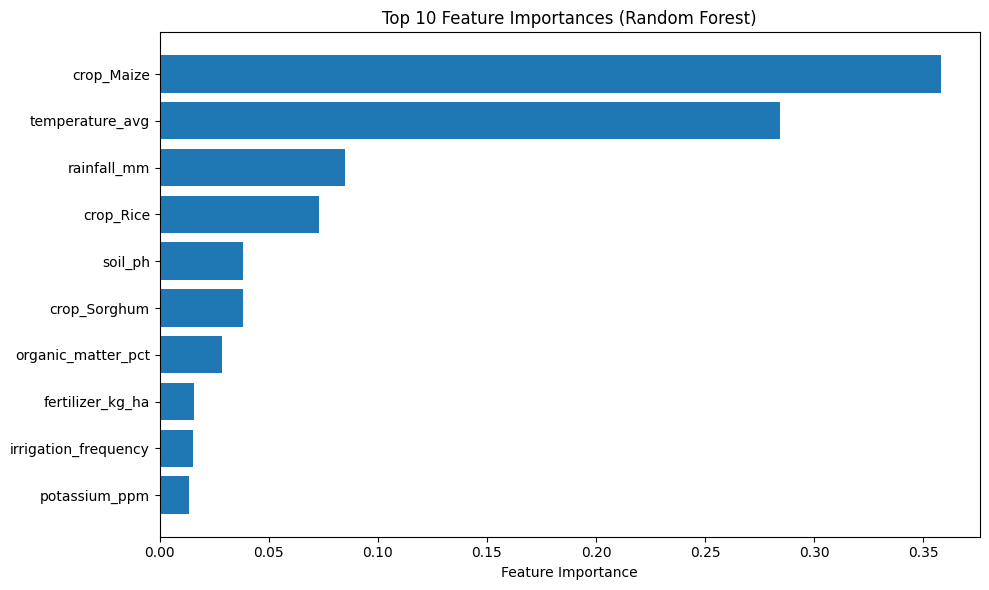

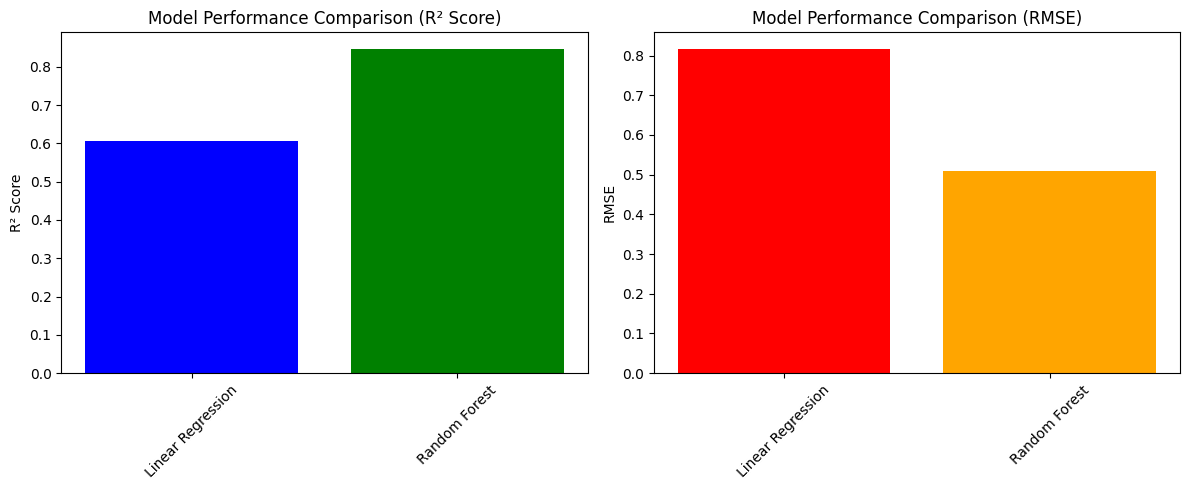

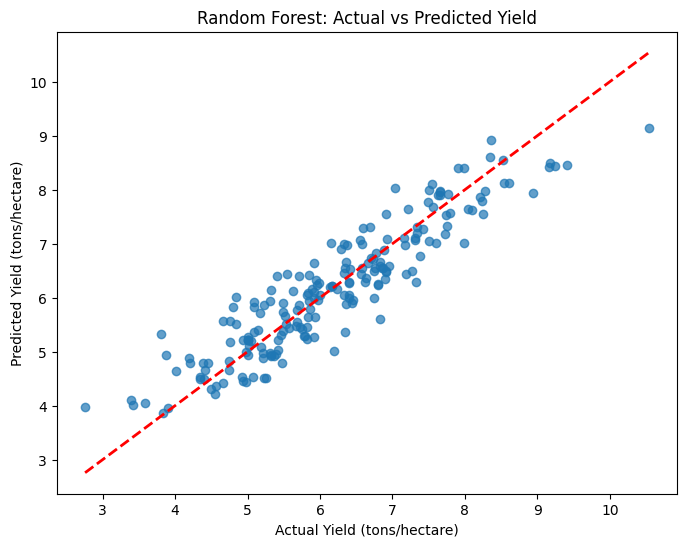

In [ ]:
# Feature importance (Random Forest)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Model performance comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models_names = list(results.keys())
r2_scores = [results[model]['R2'] for model in models_names]
plt.bar(models_names, r2_scores, color=['blue', 'green'])
plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
rmse_scores = [results[model]['RMSE'] for model in models_names]
plt.bar(models_names, rmse_scores, color=['red', 'orange'])
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# Predictions vs Actual (Random Forest)
rf_predictions = rf_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (tons/hectare)')
plt.ylabel('Predicted Yield (tons/hectare)')
plt.title('Random Forest: Actual vs Predicted Yield')
plt.show()

In [ ]:
# Save the dataset
df.to_csv('agricultural_crop_yield_data.csv', index=False)
print(f"\nDataset saved as 'agricultural_crop_yield_data.csv'")

print("\n" + "="*50)
print("ANALYSIS SUMMARY")
print("="*50)
print("• Generated synthetic agricultural dataset with 1000 samples")
print("• Analyzed relationships between environmental factors and crop yield")
print("• Implemented and compared machine learning models")
print("• Identified key factors affecting crop yield")
print("• Created comprehensive visualizations")
print("\nThis analysis demonstrates proficiency in:")
print("• Data generation and preprocessing")
print("• Exploratory data analysis and visualization")
print("• Machine learning implementation and evaluation")
print("• Agricultural domain knowledge application")


Dataset saved as 'agricultural_crop_yield_data.csv'

ANALYSIS SUMMARY
• Generated synthetic agricultural dataset with 1000 samples
• Analyzed relationships between environmental factors and crop yield
• Implemented and compared machine learning models
• Identified key factors affecting crop yield
• Created comprehensive visualizations

This analysis demonstrates proficiency in:
• Data generation and preprocessing
• Exploratory data analysis and visualization
• Machine learning implementation and evaluation
• Agricultural domain knowledge application
